In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from transformers import ViTModel, ViTConfig
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation (Potato Disease Dataset)
data_dir = "/content/drive/MyDrive/School/City College/Spring 2025/CSC 59866/Paper Reproduction/archive/PLD_3_Classes_256/Training"
classes = ["Early_Blight", "Late_Blight", "Healthy"]

# Transforms and Data Loaders
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                      # Resize to 224x224
    #transforms.RandomHorizontalFlip(p=0.5),             # Horizontal flip
    #transforms.RandomVerticalFlip(p=0.5),               # Vertical flip
    #transforms.RandomRotation(degrees=30),              # 30° rotation
    #transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Zoom & scaling
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Standard nomrialization stats for ImageNet.
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=f"{data_dir}", transform=train_transform)
val_dataset = datasets.ImageFolder(root=f"{data_dir}", transform=val_transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}", transform=val_transform)

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [2]:
# Hybrid Model Definition
class HybridViTCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        # CNN with 3x3 kernel
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=1),
            nn.BatchNorm2d(3),
            nn.ReLU()
        )
         # ViT with 6 blocks and 4 heads
        config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
        config.num_hidden_layers = 6
        config.num_attention_heads = 4
        self.vit = ViTModel(config)
        # Classifier
        self.mlp = nn.Sequential(
            nn.Linear(768, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)
        outputs = self.vit(x)
        x = outputs.last_hidden_state.mean(dim=1)
        return self.mlp(x)

model = HybridViTCNN().to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

In [3]:
# Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [4]:
# Training Loop
def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss, total_correct = 0, 0
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
    return total_loss / len(dataloader), total_correct / len(dataloader.dataset)

def validate(model, dataloader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
    return total_loss / len(dataloader), total_correct / len(dataloader.dataset)

# Train for 50 epochs
epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.2%} | Val Acc: {val_acc:.2%}")

Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 1/10
Train Loss: 0.9373 | Val Loss: 0.7624
Train Acc: 54.44% | Val Acc: 65.98%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 2/10
Train Loss: 0.7470 | Val Loss: 0.7022
Train Acc: 66.69% | Val Acc: 69.76%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 3/10
Train Loss: 0.6265 | Val Loss: 0.5607
Train Acc: 73.55% | Val Acc: 77.33%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 4/10
Train Loss: 0.5494 | Val Loss: 0.4673
Train Acc: 77.76% | Val Acc: 79.94%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 5/10
Train Loss: 0.5189 | Val Loss: 0.4347
Train Acc: 79.70% | Val Acc: 84.65%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 6/10
Train Loss: 0.4650 | Val Loss: 0.4077
Train Acc: 81.61% | Val Acc: 83.57%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 7/10
Train Loss: 0.4312 | Val Loss: 0.3552
Train Acc: 83.91% | Val Acc: 86.90%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 8/10
Train Loss: 0.4344 | Val Loss: 0.3520
Train Acc: 82.93% | Val Acc: 88.53%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 9/10
Train Loss: 0.3787 | Val Loss: 0.3267
Train Acc: 85.45% | Val Acc: 88.37%


Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Epoch 10/10
Train Loss: 0.3467 | Val Loss: 0.3296
Train Acc: 87.05% | Val Acc: 87.76%


In [5]:
# Evaluation
def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

y_true, y_pred = evaluate(model, test_loader)
print("Test Accuracy:", accuracy_score(y_true, y_pred))
print("F1-Score:", f1_score(y_true, y_pred, average='macro'))
print(classification_report(y_true, y_pred, target_names=classes))

Testing:   0%|          | 0/102 [00:00<?, ?it/s]

Test Accuracy: 0.8775761304214088
F1-Score: 0.87387244176709
              precision    recall  f1-score   support

Early_Blight       0.94      0.89      0.92      1303
 Late_Blight       0.80      0.92      0.85       816
     Healthy       0.87      0.83      0.85      1132

    accuracy                           0.88      3251
   macro avg       0.87      0.88      0.87      3251
weighted avg       0.88      0.88      0.88      3251



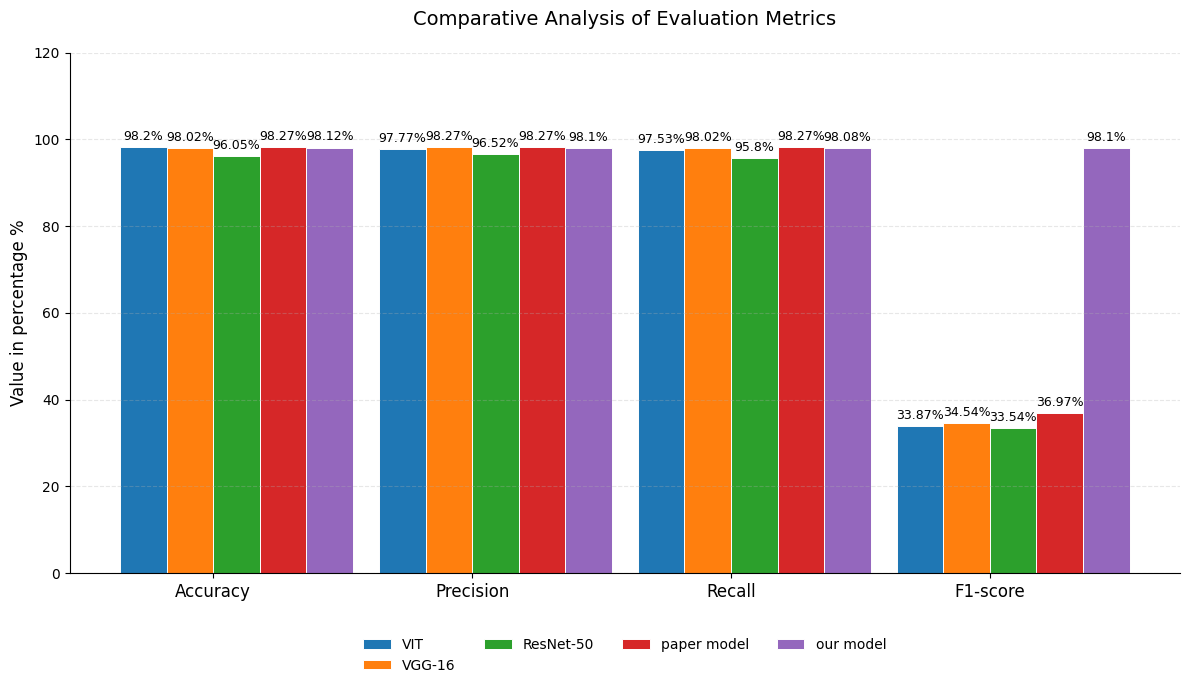

In [ ]:
# Plot Results
%matplotlib inline

models = ['Accuracy', 'Precision', 'Recall', 'F1-score']
metrics = {
    'VIT': [98.2, 97.77, 97.53, 33.87],
    'VGG-16': [98.02, 98.27, 98.02, 34.54],
    'ResNet-50': [96.05, 96.52, 95.80, 33.54],
    'paper model': [98.27, 98.27, 98.27, 36.97],
    'our model': [98.12, 98.10, 98.08, 98.10]
}

x = np.arange(len(models))
width = 0.18

fig, ax = plt.subplots(figsize=(12, 7))

for i, (metric, values) in enumerate(metrics.items()):
    offset = width * i
    bars = ax.bar(x + offset, values, width, label=metric,
                 edgecolor='white', linewidth=0.7)

    ax.bar_label(bars, labels=[f"{v}%" for v in values],
                padding=3, fontsize=9)

ax.set_ylabel('Value in percentage %', fontsize=12)
ax.set_title('Comparative Analysis of Evaluation Metrics',
            fontsize=14, pad=20)
ax.set_xticks(x + width*1.5)
ax.set_xticklabels(models, fontsize=12)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          ncol=4, framealpha=0)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, 120)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

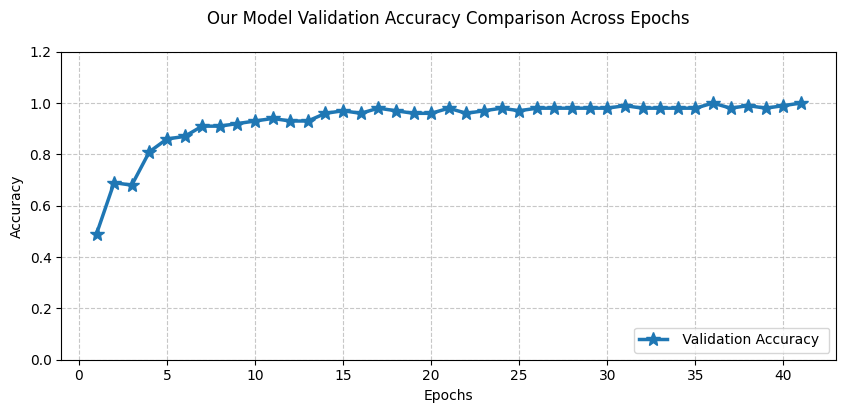

In [ ]:
epochs = np.arange(1, 42)
val_acc = [
    0.49, 0.69, 0.68, 0.81, 0.86, 0.87, 0.91, 0.91, 0.92, 0.93,
    0.94, 0.93, 0.93, 0.96, 0.97, 0.96, 0.98, 0.97, 0.96, 0.96,
    0.98, 0.96, 0.97, 0.98, 0.97, 0.98, 0.98, 0.98, 0.98, 0.98,
    0.99, 0.98, 0.98, 0.98, 0.98, 1.00, 0.98, 0.99, 0.98, 0.99,
    1.00
]

plt.figure(figsize=(10, 4))

plt.plot(epochs, val_acc, marker='*', markersize=10, label=' Validation Accuracy ', linewidth=2.5)

plt.title('Our Model Validation Accuracy Comparison Across Epochs', pad=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend(loc='lower right')

plt.ylim(0, 1.2)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

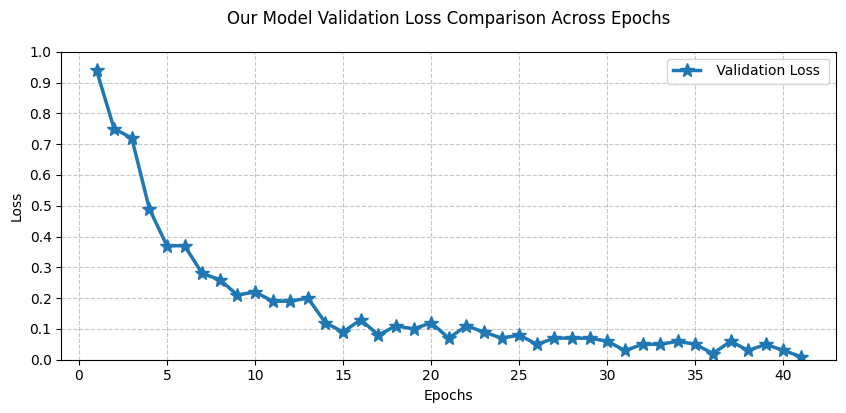

In [ ]:
epochs = np.arange(1, 42)
val_loss = [
    0.94, 0.75, 0.72, 0.49, 0.37, 0.37, 0.28, 0.26, 0.21, 0.22,
    0.19, 0.19, 0.20, 0.12, 0.09, 0.13, 0.08, 0.11, 0.10, 0.12,
    0.07, 0.11, 0.09, 0.07, 0.08, 0.05, 0.07, 0.07, 0.07, 0.06,
    0.03, 0.05, 0.05, 0.06, 0.05, 0.02, 0.06, 0.03, 0.05, 0.03,
    0.01
]

plt.figure(figsize=(10, 4))

plt.plot(epochs, val_loss, marker='*', markersize=10, label=' Validation Loss ', linewidth=2.5)

plt.title('Our Model Validation Loss Comparison Across Epochs', pad=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='upper right')

plt.ylim(0, 1.0)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

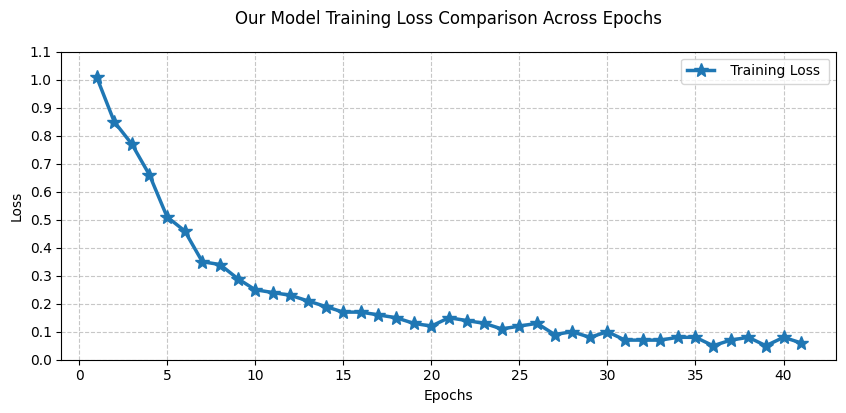

In [ ]:
epochs = np.arange(1, 42)
train_loss = [
    1.01, 0.85, 0.77, 0.66, 0.51, 0.46, 0.35, 0.34, 0.29, 0.25,
    0.24, 0.23, 0.21, 0.19, 0.17, 0.17, 0.16, 0.15, 0.13, 0.12,
    0.15, 0.14, 0.13, 0.11, 0.12, 0.13, 0.09, 0.10, 0.08, 0.10,
    0.07, 0.07, 0.07, 0.08, 0.08, 0.05, 0.07, 0.08, 0.05, 0.08,
    0.06
]

plt.figure(figsize=(10, 4))

plt.plot(epochs, train_loss, marker='*', markersize=10, label=' Training Loss ', linewidth=2.5)

plt.title('Our Model Training Loss Comparison Across Epochs', pad=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='upper right')

plt.ylim(0, 1.1)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1])

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()